# Thrombin ligands for pharmacophore identification

We explore thrombing ligands that will be used to create ligand-based pharmacophore models.

In [1]:
import openpharmacophore as oph

import pandas as pd
import rdkit.Chem.AllChem as Chem
from rdkit.Chem import Draw
import nglview as nv

from copy import deepcopy
from collections import defaultdict
from pprint import pprint
import os

from IPython.display import SVG
from tqdm.auto import tqdm

from read_sdf import read_sdf

## Load  and visualize ligands

We load the ligands from their respective smiles and draw their molecular structures

In [2]:
lig_df = pd.read_csv("ligands.csv")
lig_df

Smiles PDBID LigID
0  [H]/N=C(\C1CCC(CC1)CNC(=O)[C@@H]2C=C(CN3N2C(=O...  1C4V   IH2
1  CN[C@H](Cc1ccccc1)C(=O)N2CCC[C@H]2C(=O)NCC3CCC...  1TOM   MIN
2  c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...  1D6W   00R
3  c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...  1D91   00P
4  [H]/N=C(/c1ccc(cc1)C[C@H](C(=O)N2CCCCC2)NC(=O)...  1DWD   MID
5  [H]/N=C(\c1ccc2c(c1)cc([nH]2)C(=O)N3CCC(CC3)Cc...  1D4P   BPP
6  CCC1CCN(CC1)C(=O)[C@H](CCCNC(=[NH2+])N)NS(=O)(...  1FPC   0ZI

In [3]:
def load_ligands():
    """ Load the ligands into a list of rdkit molecules."""
    ligands = []
    
    smiles = lig_df["Smiles"]
    pdb_ids = lig_df["PDBID"]
    
    for ii in range(len(smiles)):
        mol = Chem.MolFromSmiles(smiles[ii].encode("unicode_escape"))
        mol.SetProp("_Name", pdb_ids[ii])
        assert mol is not None
        ligands.append(mol)

    print(f"Num ligands: {len(ligands)}")
    return ligands

Num ligands: 7


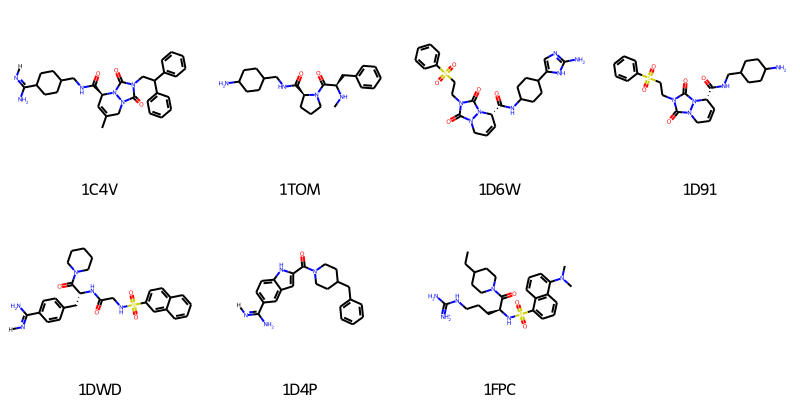

In [4]:
ligands = load_ligands()
legends = [l.GetProp("_Name") for l in ligands]
Draw.MolsToGridImage(ligands, legends=legends, molsPerRow=4)

## Preparing the ligands

We'll generate different conformers for each of the ligands and add hydrogens to them
as well.

In [5]:
pharmacophore = oph.LigandBasedPharmacophore()
pharmacophore.ligands = ligands

### Generating conformers

In [6]:
# Load conformers from file if present
conf_file = "./thrombin_ligands.sdf"
if os.path.isfile(conf_file):
    pharmacophore.ligands = read_sdf(conf_file)
else:
    pharmacophore.generate_conformers(n_confs=-1, ligands="all")
    
print([l.GetNumConformers() for l in pharmacophore.ligands])

[178, 171, 164, 153, 170, 42, 281]


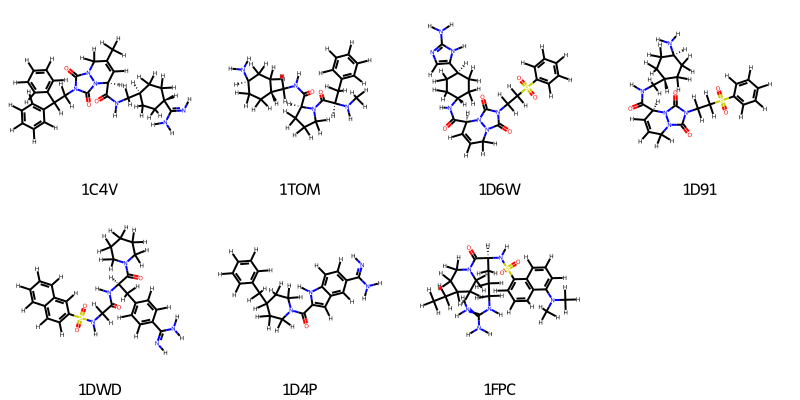

In [7]:
ligs_no_conf = [
    Chem.Mol(lig) for lig in pharmacophore.ligands
]
for lig in ligs_no_conf:
    lig.RemoveAllConformers()
Draw.MolsToGridImage(ligs_no_conf, legends=legends, molsPerRow=4)

In [8]:
# Save conformers to file
if not os.path.isfile(conf_file):
    writer = Chem.SDWriter("./thrombin_ligands.sdf")
    for lig in pharmacophore.ligands:
        for conf in range(lig.GetNumConformers()):
            writer.write(lig, confId=conf)
    writer.close()

## View 3D structures

In [9]:
lig_ind = 2
conf_ind = 2
nv.show_rdkit(pharmacophore.ligands[lig_ind], conf_ind=conf_ind)

NGLWidget()

## Chemical features

We find chemical features in the ligands and visualize them.

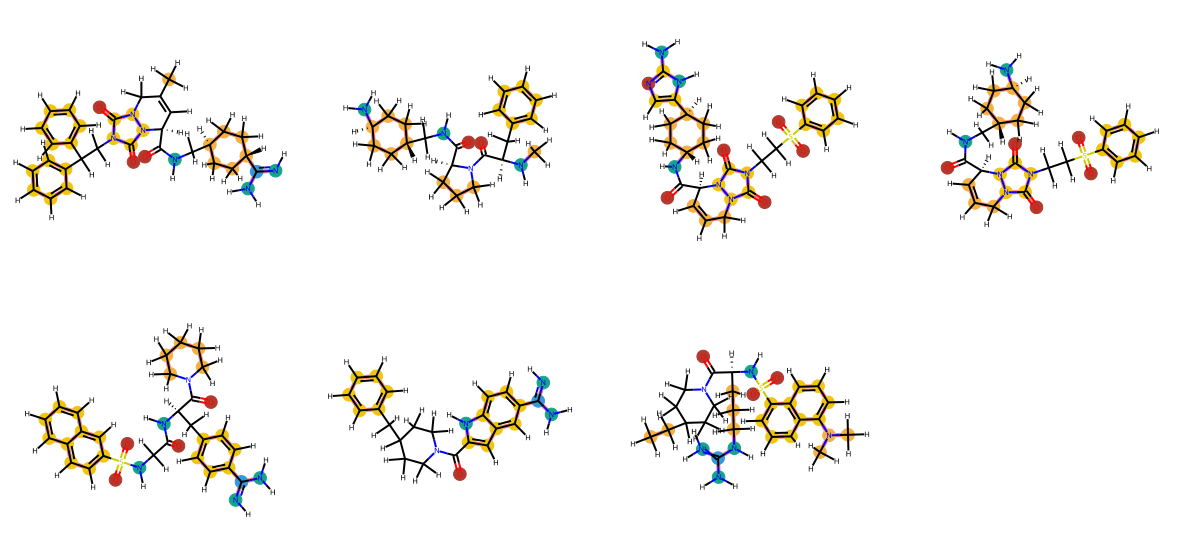

In [10]:
pharmacophore.find_chem_feats()
drawing = pharmacophore.draw((300, 280))
SVG(drawing.GetDrawingText())

In [11]:
# Count the ocurrence of each chemical feature type in
# each ligand
def chem_feats_df(chem_feats, lgnds):
    
    feat_count = {
        "A": [],
        "D": [],
        "H": [],
        "P": [],
        "N": [],
        "R": [],
    }
    
    for ligand_feats in chem_feats:
        for feat_type, indices in ligand_feats.items():
            feat_count[feat_type].append(len(indices))
            
    columns = [
        "Acceptor", "Donor", "Hydrophobic", 
        "Positive", "Negative", "Ring",
    ]
    df = pd.DataFrame.from_dict(feat_count)
    df.columns = columns
    df.index = lgnds
    return df

In [12]:
chem_feats_df(pharmacophore.feats, legends)

Acceptor  Donor  Hydrophobic  Positive  Negative  Ring
1C4V         3      3            2         1         0     3
1TOM         4      3            3         2         0     1
1D6W         6      3            2         0         0     3
1D91         6      2            2         1         0     2
1DWD         5      4            2         1         0     3
1D4P         2      3            0         1         0     3
1FPC         3      4            4         2         0     2

## Extracting common pharmacophores

We extract common pharmacophores via recursive distance partitioning algorithm

In [13]:
def pharmacophore_df(lbp):
    
    info = {
        "Features": [],
        "Score": [],
        "Ref Ligand Name": [],
        "Ref Ligand Id": [],
        "Ref Conformer": [],
    }
    
    for pharma in lbp:
        variant = "".join([p.short_name for p in pharma])
        info["Features"].append(variant)
        info["Score"].append(pharma.score)
        
        ref_lig = pharma.ref_mol
        info["Ref Ligand Id"].append(ref_lig)
        info["Ref Ligand Name"].append(lbp.ligands[ref_lig].GetProp("_Name"))
        info["Ref Conformer"].append(pharma.ref_struct)
        
    df = pd.DataFrame.from_dict(info)
    df.index = ["Pharmacophore " + str(ii) for ii in range(len(lbp))]
    return df

### Finding 5-Point Pharmacophores

In [14]:
min_actives = len(pharmacophore.ligands) - 2
n_points = 5

In [15]:
pharmacophore.extract(
    n_points=n_points, min_actives=min_actives, max_pharmacophores=10
)
print(f"Found {len(pharmacophore)} common pharmacophores")

Found 10 common pharmacophores


In [16]:
view = pharmacophore.show(0)
view

NGLWidget()

In [17]:
pharmacophore_df(pharmacophore)

Features     Score Ref Ligand Name  Ref Ligand Id  \
Pharmacophore 0    AAAHR  0.811521            1D6W              2   
Pharmacophore 1    AADDH  0.623514            1FPC              6   
Pharmacophore 2    AADDH  0.587655            1FPC              6   
Pharmacophore 3    AADDH  0.576535            1FPC              6   
Pharmacophore 4    AADDH  0.564456            1FPC              6   
Pharmacophore 5    AADDH  0.559310            1FPC              6   
Pharmacophore 6    AADDR  0.449722            1DWD              4   
Pharmacophore 7    AADDR  0.447580            1FPC              6   
Pharmacophore 8    AADDR  0.431004            1D91              3   
Pharmacophore 9    AADDR  0.421616            1FPC              6   

                 Ref Conformer  
Pharmacophore 0             87  
Pharmacophore 1            183  
Pharmacophore 2            143  
Pharmacophore 3            189  
Pharmacophore 4             57  
Pharmacophore 5            202  
Pharmacophore 6             44  
Pharmacophore 7             92  
Pharmacophore 8             59  
Pharmacophore 9             31

### Finding 3-Point Pharmacophores

In [18]:
min_actives = len(pharmacophore.ligands)
n_points = 3

pharma_3 = oph.LigandBasedPharmacophore()
pharma_3.ligands = pharmacophore.ligands
pharma_3.find_chem_feats()
pharma_3.extract(
    n_points=n_points, min_actives=min_actives, max_pharmacophores=10
)

print(f"Found {len(pharma_3)} common pharmacophores")

Found 10 common pharmacophores


In [19]:
pharma_3.show(0)

NGLWidget()

In [20]:
pharmacophore_df(pharma_3)

Features     Score Ref Ligand Name  Ref Ligand Id  \
Pharmacophore 0      ADD  0.716317            1DWD              4   
Pharmacophore 1      ADD  0.700461            1DWD              4   
Pharmacophore 2      ADD  0.598621            1D6W              2   
Pharmacophore 3      ADD  0.582764            1FPC              6   
Pharmacophore 4      ADD  0.577239            1D6W              2   
Pharmacophore 5      ADD  0.572925            1FPC              6   
Pharmacophore 6      ADD  0.572416            1DWD              4   
Pharmacophore 7      ADD  0.543262            1FPC              6   
Pharmacophore 8      ADD  0.526605            1D6W              2   
Pharmacophore 9      ADD  0.481530            1D6W              2   

                 Ref Conformer  
Pharmacophore 0             94  
Pharmacophore 1            108  
Pharmacophore 2             85  
Pharmacophore 3            277  
Pharmacophore 4              9  
Pharmacophore 5            257  
Pharmacophore 6            161  
Pharmacophore 7             95  
Pharmacophore 8            107  
Pharmacophore 9             32

### Finding 4-Point Pharmacophores

In [21]:
min_actives = len(pharmacophore.ligands)
n_points = 4

pharma_4 = oph.LigandBasedPharmacophore()
pharma_4.ligands = pharmacophore.ligands
pharma_4.find_chem_feats()
pharma_4.extract(
    n_points=n_points, min_actives=min_actives, max_pharmacophores=10
)

print(f"Found {len(pharma_4)} common pharmacophores")

Found 5 common pharmacophores


In [22]:
pharma_4.show(0)

NGLWidget()

In [23]:
pharmacophore_df(pharma_4)

Features     Score Ref Ligand Name  Ref Ligand Id  \
Pharmacophore 0     ADDR  0.660154            1DWD              4   
Pharmacophore 1     ADDR  0.644129            1DWD              4   
Pharmacophore 2     ADDR  0.624931            1DWD              4   
Pharmacophore 3     ADDR  0.514479            1DWD              4   
Pharmacophore 4     ADDR  0.446420            1D4P              5   

                 Ref Conformer  
Pharmacophore 0             94  
Pharmacophore 1            150  
Pharmacophore 2             92  
Pharmacophore 3             85  
Pharmacophore 4             21

## Pharmacophores from protein-ligand complexes

We compare the ligand-based pharmacophore models with the ones obtained from the crystal structure
of the protein-ligand complex

In [24]:
def ligand_receptor_pharmacophores():
    """ Load pdb files anc create ligand recpetor pharmacophores for each.
    """

    lrp = []
    for _, _, filenames in os.walk("./"):
        for file in filenames:
            if file.endswith(".pdb"):
                pharma = oph.load(file)
                lig_ids = pharma.receptor.ligand_ids
                
                pdb_id = file.split(".")[0]
                print(f"PDB {pdb_id} contains {len(lig_ids)} ligand(s):")
                print(lig_ids, '\n')

                lrp.append(pharma)
        
    return lrp

In [25]:
lr_pharma = ligand_receptor_pharmacophores()

PDB 1d4p contains 2 ligand(s):
['NAG:D', 'BPP:D'] 

PDB 1fpc contains 1 ligand(s):
['0ZI:D'] 

PDB 1d6w contains 1 ligand(s):
['00R:C'] 

PDB 1c4v contains 1 ligand(s):
['IH2:D'] 

PDB 1tom contains 1 ligand(s):
['MIN:D'] 

PDB 1d9i contains 1 ligand(s):
['00P:C'] 

PDB 1dwd contains 1 ligand(s):
['MID:D'] 



In [26]:
from openpharmacophore._private_tools.exceptions import MolGraphError

In [27]:
def extract_pharmacophores(lrp):
    """ Extract pharmacophores. If a phamracophore is failed to be extracted.
        its moved to a new list.
    """
    fails_ind = []
    for ii, pharma in enumerate(lrp):
        lig_id = pharma.receptor.ligand_ids[-1]
        lig_name = lig_id.split(":")[0]
        
        row = lig_df[lig_df["LigID"] == lig_name]
        if len(row) == 1:
            smiles = row["Smiles"].iloc[0]
        else:
            smiles = None
        
        try:
            pharma.extract(lig_id, smiles=smiles)
        except MolGraphError:
            print(f"Error with pdb {pharma.receptor._file_path}")
            fails_ind.append(ii)
    
    fails = [lrp[ii] for ii in fails_ind]
    pharmas = [lrp[ii] for ii in range(len(lrp)) if ii not in fails_ind]
    return pharmas, fails

In [28]:
lr_pharma, fails = extract_pharmacophores(lr_pharma)
print(f"\nExtracted {len(lr_pharma)} pharmacophores")
print(f"Failed to extact {len(fails)} pharmacophores")

Error with pdb 1c4v.pdb

Extracted 6 pharmacophores
Failed to extact 1 pharmacophores


In [32]:
index = 2
print(lr_pharma[index].receptor.ligand_ids[-1])
lr_pharma[index].show(receptor=False)

00R:E


NGLWidget()